In [8]:
import os
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import kaldiio

from scipy.signal import welch
import random
from sklearn.manifold import TSNE
import plotly.graph_objects as go

import plotly.io as pio

pio.renderers.default = "notebook"

from IPython.display import Audio
import torchaudio

import tensorflow as tf

load_dotenv("../.env")
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
PROJECT_ROOT = os.getenv("PROJECT_ROOT")
os.chdir(PROJECT_ROOT)

CLIPS_PATH = os.getenv("CLIPS_PATH")

VALIDATED_LIST_PATH = os.path.join(os.getenv("CLIPS_META_PATH"), "validated.tsv")
XVECTOR_RESULT_PATH = os.getenv("XVECTOR_RESULT_PATH")
XVECTOR_SCP_PATH = os.path.join(XVECTOR_RESULT_PATH, "xvector.scp")

In [10]:
speakers_xvectors = kaldiio.load_scp(XVECTOR_SCP_PATH)
valid_speakers = set(speakers_xvectors.keys())

raw_clips_meta = pd.read_table(VALIDATED_LIST_PATH)
raw_clips_meta = raw_clips_meta[raw_clips_meta["client_id"].isin(valid_speakers)]


def get_path(row):
    return f"{CLIPS_PATH}/{row['path'].values[0]}.mp3"

In [11]:
audio_file = get_path(raw_clips_meta.sample())
waveform, sample_rate = torchaudio.load(audio_file)

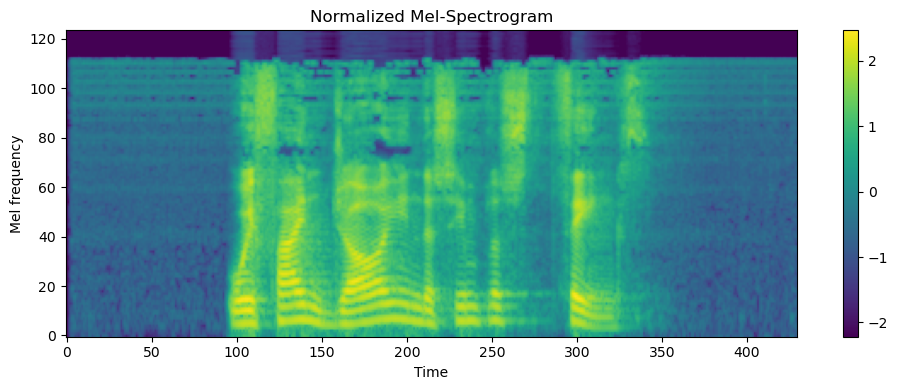

In [12]:
n_mels = 124
n_fft = 2048
hop_length = 512
win_length = n_fft


mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels,
)(waveform)
mel_spectrogram_db = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)

mel_spectrogram_db_mean = tf.reduce_mean(mel_spectrogram_db)
mel_spectrogram_db_std = tf.math.reduce_std(mel_spectrogram_db)
mel_spectrogram_normalized = (
    mel_spectrogram_db - mel_spectrogram_db_mean
) / mel_spectrogram_db_std

# Plot the normalized mel-spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(
    mel_spectrogram_normalized.numpy().squeeze(),
    origin="lower",
    aspect="auto",
    cmap="viridis",
)
plt.colorbar()
plt.title("Normalized Mel-Spectrogram")
plt.xlabel("Time")
plt.ylabel("Mel frequency")
plt.tight_layout()
plt.show()

In [ ]:
def generate_white_noise(audio_length, sr):
    return np.random.normal(0, 1, audio_length)


def generate_pink_noise(audio_length, sr):
    num_freqs, _ = welch(np.ones(audio_length), fs=sr)
    pink_spectrum = 1 / np.sqrt(np.linspace(1, sr // 2, num_freqs))
    pink_noise = np.fft.irfft(
        pink_spectrum * np.fft.rfft(generate_white_noise(audio_length, sr))
    )
    return pink_noise


def add_noise(audio, snr, noise_type="white", sr=None, noise_file=None):
    audio_power = np.sum(audio**2)

    if noise_type == "white":
        noise = generate_white_noise(len(audio), sr)
    elif noise_type == "pink":
        noise = generate_pink_noise(len(audio), sr)
    elif noise_type == "file":
        if noise_file is None:
            raise ValueError("noise_file must be specified for noise_type 'file'")
        noise, _ = librosa.load(noise_file, sr=sr)
    else:
        raise ValueError("Invalid noise_type, choose from 'white', 'pink', or 'file'")

    noise_power = np.sum(noise**2)
    target_noise_power = audio_power / (10 ** (snr / 10))
    noise_scaling_factor = np.sqrt(target_noise_power / noise_power)
    noisy_audio = audio + noise_scaling_factor * noise
    return noisy_audio


def mix_speakers(*clips):
    max_duration = max([clip.shape[0] for clip in clips])
    mixed_audio = np.zeros(max_duration)

    for clip in clips:
        padded_clip = np.pad(clip, (0, max_duration - clip.shape[0]), mode="constant")
        mixed_audio += padded_clip

    return mixed_audio

In [25]:
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    Concatenate,
    LeakyReLU,
    BatchNormalization,
    Flatten,
    AveragePooling2D,
    Dense,
    Dropout,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Model

In [21]:
HYPER_PARAMS = {
    # Model parameters
    "window-width": 64,
    "mel-bands": 256,
    "x-vector-dim": 512,
    # Training parameters
    "batch-size": 32,
    "epochs": 100,
    "learning-rate": 0.0001,
}

# Model parameters
mel_spectrogram_shape = (
    HYPER_PARAMS["window-width"],
    HYPER_PARAMS["mel-bands"],
    1,
)  # Replace window_size and num_mel_bands with your values

# Leaky ReLU activation function
leaky_relu = LeakyReLU(alpha=0.2)

# Mel-spectrogram input
mel_spectrogram_input = Input(shape=mel_spectrogram_shape, name="mel_spectrogram_input")

# Convolutional layers
x = Conv2D(16, (3, 3), padding="same", activation=leaky_relu)(mel_spectrogram_input)
x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Convolutional layers
x = Conv2D(32, (3, 3), padding="same", activation=leaky_relu)(mel_spectrogram_input)
x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), padding="same", activation=leaky_relu)(x)
x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), padding="same", activation=leaky_relu)(x)
x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)

# X-vector input
x_vector_input = Input(shape=(HYPER_PARAMS["x-vector-dim"],), name="x_vector_input")

# Concatenate flattened CNN output with x-vector input
combined_input = Concatenate()([x, x_vector_input])

# Dense layers
y = Dense(128, activation=leaky_relu)(combined_input)
y = Dropout(0.1)(y)
y = Dense(256, activation=leaky_relu)(y)
y = Dropout(0.1)(y)
y = Dense(256, activation=leaky_relu)(y)
y = Dropout(0.1)(y)
y = Dense(512, activation=leaky_relu)(y)
output = Dense(HYPER_PARAMS["mel-bands"], activation="linear")(y)

# Construct the model
model = Model(inputs=[mel_spectrogram_input, x_vector_input], outputs=output)
model.summary()

# Compile the model
optimizer = Adam(learning_rate=HYPER_PARAMS["learning-rate"])
loss_fn = MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss_fn)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mel_spectrogram_input (InputLay [(None, 64, 256, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 64, 256, 32)  320         mel_spectrogram_input[0][0]      
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 64, 256, 32)  128         conv2d_19[0][0]                  
__________________________________________________________________________________________________
average_pooling2d_19 (AveragePo (None, 32, 128, 32)  0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

In [27]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard_callback = TensorBoard(histogram_freq=1)

2023-04-20 00:06:36.918270: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-04-20 00:06:36.918562: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-04-20 00:06:36.921562: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2023-04-20 00:06:36.960671: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2023-04-20 00:06:38.425261: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-04-20 00:06:38.425465: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


In [ ]:
# Training parameters
epochs = 50
train_steps_per_epoch = 2000  # Adjust this value based on your training set size
val_steps_per_epoch = 500     # Adjust this value based on your validation set size

for epoch in tqdm(range(HYPER_PARAMS["epochs"]), desc="Training"):
    pass
    # Train on batches
    # for batch_X_mel, batch_X_xvec, batch_y in train_dataset:
    #     train_result = model.train_on_batch(
    #         x=[batch_X_mel, batch_X_xvec], y=batch_y, reset_metrics=False
    #     )

    #     # Write train metrics to TensorBoard
    #     with tensorboard_callback.as_default():
    #         tf.summary.scalar("loss", train_result, step=epoch)

    # Validate on batches
    # val_losses = []
    # for batch_X_mel, batch_X_xvec, batch_y in val_dataset:
    #     val_result = model.test_on_batch(x=[batch_X_mel, batch_X_xvec], y=batch_y)

    #     # Collect validation losses
    #     val_losses.append(val_result)

    # Write validation metrics to TensorBoard
    # mean_val_loss = np.mean(val_losses)
    # with tensorboard_callback.as_default():
    #     tf.summary.scalar("val_loss", mean_val_loss, step=epoch)